<a href="https://colab.research.google.com/github/marhooo/AKMMH/blob/main/%D0%90%D0%9A%D0%9C%D0%9C%D0%9D_%D0%A4%D0%91_52%D0%BC%D0%BF_%D0%9F%D0%B5%D1%88%D0%BA%D0%BE%D0%B2%D0%B0_%D0%9C%D0%B0%D1%80%D0%B3%D0%B0%D1%80%D0%B8%D1%82%D0%B0_%D0%91%D0%BE%D0%BD%D0%B4%D0%B0%D1%80%D0%B5%D0%BD%D0%BA%D0%BE_%D0%AF%D0%BD%D0%B0_%D0%9F%D1%80_9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Аналіз кіберінцидентів методами машинного навчання
Практична робота №9

Тема: Нейронні мережі в системах машинного навчання

Налаштування середовища

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import os

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: []


Завантаження і підготовка даних (MNIST)

In [ ]:
from tensorflow.keras.datasets import mnist
# Завантажуємо MNIST (60k train, 10k test)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перевіримо розміри
print("x_train shape:", x_train.shape, "y_train shape:", y_train.shape)
print("x_test shape:", x_test.shape, "y_test shape:", y_test.shape)

# Нормалізація до [0,1]
x_train = x_train.astype('float32') / 255.0
x_test  = x_test.astype('float32')  / 255.0

# Для dense-мережі необхідно "розгорнути" зображення у вектор розмірності 28*28
x_train_flat = x_train.reshape((-1, 28*28))
x_test_flat  = x_test.reshape((-1, 28*28))

# Для CNN потрібен канал (height, width, 1)
x_train_cnn = x_train.reshape((-1,28,28,1))
x_test_cnn  = x_test.reshape((-1,28,28,1))

num_classes = 10


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
x_train shape: (60000, 28, 28) y_train shape: (60000,)
x_test shape: (10000, 28, 28) y_test shape: (10000,)


Візуалізація прикладів

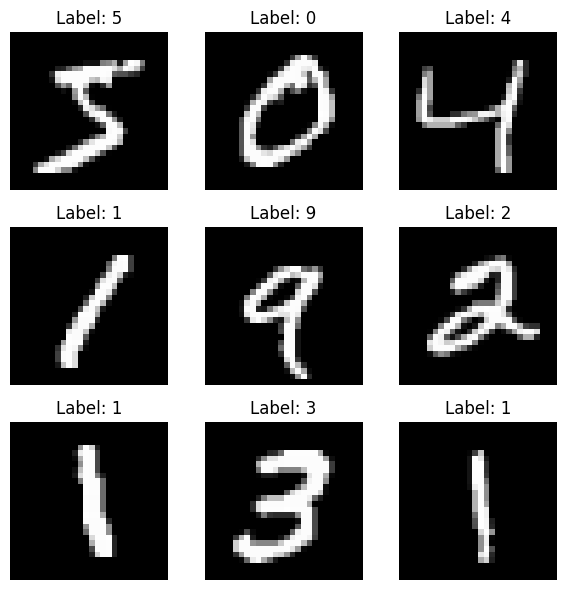

In [ ]:
def show_samples(X, y, n=9):
    plt.figure(figsize=(6,6))
    for i in range(n):
        plt.subplot(3,3,i+1)
        plt.imshow(X[i], cmap='gray')
        plt.title(f"Label: {y[i]}")
        plt.axis('off')
    plt.tight_layout()
show_samples(x_train, y_train)


Наступний блок створює базову модель MLP (багатошаровий перцептрон) для класифікації зображень, використовуючи щільні (Dense) шари з функцією активації ReLU та dropout для регуляризації. Модель компілюється з оптимізатором Adam та категоріальною крос-ентропією і готова до навчання на підготовлених даних.

In [ ]:
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes)
y_test_cat  = to_categorical(y_test, num_classes)

def build_mlp(hidden_units=128, dropout=0.2):
    model = models.Sequential([
        layers.Input(shape=(28*28,)),
        layers.Dense(hidden_units, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(hidden_units//2, activation='relu'),
        layers.Dropout(dropout),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

mlp = build_mlp()
mlp.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,386 (427.29 KB)

 Trainable params: 109,386 (427.29 KB)

 Non-trainable params: 0 (0.00 B)

Навчання MLP

In [ ]:
history_mlp = mlp.fit(x_train_flat, y_train_cat,
                      validation_split=0.1,
                      epochs=10,
                      batch_size=128)


Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.7512 - loss: 0.8026 - val_accuracy: 0.9575 - val_loss: 0.1524
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9325 - loss: 0.2265 - val_accuracy: 0.9677 - val_loss: 0.1132
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9513 - loss: 0.1622 - val_accuracy: 0.9760 - val_loss: 0.0847
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9624 - loss: 0.1258 - val_accuracy: 0.9775 - val_loss: 0.0813
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9670 - loss: 0.1087 - val_accuracy: 0.9778 - val_loss: 0.0773
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9708 - loss: 0.0935 - val_accuracy: 0.9780 - val_loss: 0.0722
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9740 - loss: 0.0889 - val_accuracy: 0.9787 - val_loss: 0.0712
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9755 - loss: 0.0767 - val_accuracy: 0.

Проведемо оцінку точністі навченої MLP-моделі на тестових даних (precision, recall, F1-score) та побудуємо матрицю плутанини для візуалізації точності передбачень по класах.

MLP Test accuracy: 0.9796, loss: 0.0692
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.9798    0.9908    0.9853       980
           1     0.9903    0.9921    0.9912      1135
           2     0.9769    0.9835    0.9802      1032
           3     0.9689    0.9861    0.9774      1010
           4     0.9855    0.9674    0.9764       982
           5     0.9887    0.9787    0.9837       892
           6     0.9813    0.9875    0.9844       958
           7     0.9783    0.9669    0.9726      1028
           8     0.9793    0.9702    0.9747       974
           9     0.9674    0.9713    0.9693      1009

    accuracy                         0.9796     10000
   macro avg     0.9796    0.9795    0.9795     10000
weighted avg     0.9796    0.9796    0.9796     10000



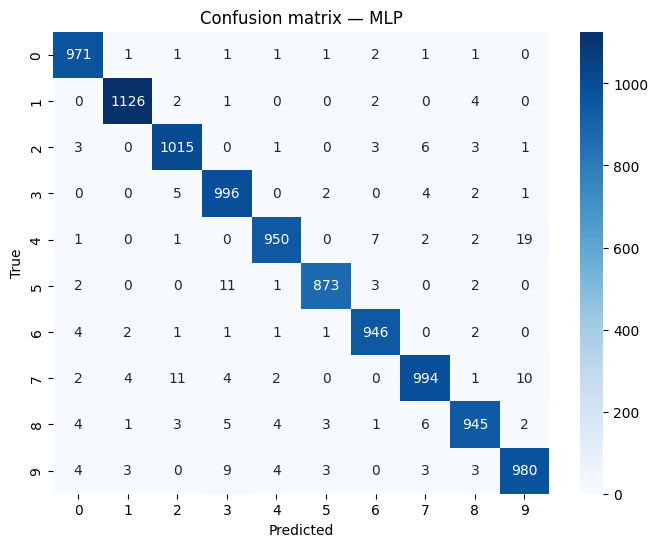

In [ ]:
# Оцінка на тесті
test_loss, test_acc = mlp.evaluate(x_test_flat, y_test_cat, verbose=0)
print(f"MLP Test accuracy: {test_acc:.4f}, loss: {test_loss:.4f}")

# Прогнози та докладні метрики
y_pred_proba = mlp.predict(x_test_flat)
y_pred = np.argmax(y_pred_proba, axis=1)

print("\nClassification report (MLP):")
print(classification_report(y_test, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion matrix — MLP")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Побудуємо також графіки loss/accuracy для MLP

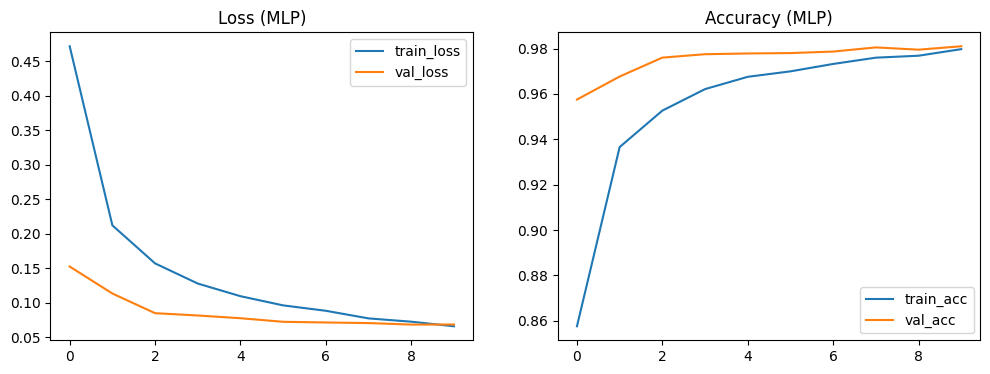

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_mlp.history['loss'], label='train_loss')
plt.plot(history_mlp.history['val_loss'], label='val_loss')
plt.title('Loss (MLP)')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_mlp.history['accuracy'], label='train_acc')
plt.plot(history_mlp.history['val_accuracy'], label='val_acc')
plt.title('Accuracy (MLP)')
plt.legend()
plt.show()


Наступний блок створює покращену модель CNN для класифікації зображень, використовуючи згорткові шари (`Conv2D`) з функцією ReLU, підвибірку через `MaxPooling2D` та dense-шари з dropout для регуляризації. Модель компілюється з оптимізатором Adam і категоріальною крос-ентропією та готова до навчання на 2D-зображеннях.


In [ ]:
def build_cnn():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

cnn = build_cnn()
cnn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

Навчання CNN

In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
]
history_cnn = cnn.fit(x_train_cnn, y_train_cat,
                      validation_split=0.1,
                      epochs=12,
                      batch_size=128,
                      callbacks=callbacks)


Epoch 1/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 48s 107ms/step - accuracy: 0.8233 - loss: 0.5827 - val_accuracy: 0.9798 - val_loss: 0.0652
Epoch 2/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 45s 106ms/step - accuracy: 0.9746 - loss: 0.0831 - val_accuracy: 0.9877 - val_loss: 0.0460
Epoch 3/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 43s 102ms/step - accuracy: 0.9832 - loss: 0.0582 - val_accuracy: 0.9870 - val_loss: 0.0406
Epoch 4/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 102ms/step - accuracy: 0.9859 - loss: 0.0462 - val_accuracy: 0.9900 - val_loss: 0.0389
Epoch 5/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 82s 104ms/step - accuracy: 0.9884 - loss: 0.0360 - val_accuracy: 0.9910 - val_loss: 0.0346
Epoch 6/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 81s 102ms/step - accuracy: 0.9905 - loss: 0.0294 - val_accuracy: 0.9903 - val_loss: 0.0341
Epoch 7/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 46s 108ms/step - accuracy: 0.9913 - loss: 0.0258 - val_accuracy: 0.9920 - val_loss: 0.0341
Epoch 8/12
422/422 ━━━━━━━━━━━━━━━━━━━━ 80s 103ms/step - accuracy: 0.9926 - loss: 0

Оцінка CNN і метрики, побудова матриці даних

CNN Test accuracy: 0.9930, loss: 0.0212
313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step

Classification report (CNN):
              precision    recall  f1-score   support

           0     0.9939    0.9949    0.9944       980
           1     0.9956    0.9947    0.9952      1135
           2     0.9923    0.9932    0.9927      1032
           3     0.9950    0.9901    0.9926      1010
           4     0.9919    0.9990    0.9954       982
           5     0.9867    0.9944    0.9905       892
           6     0.9948    0.9927    0.9937       958
           7     0.9912    0.9883    0.9898      1028
           8     0.9908    0.9949    0.9928       974
           9     0.9970    0.9881    0.9925      1009

    accuracy                         0.9930     10000
   macro avg     0.9929    0.9930    0.9930     10000
weighted avg     0.9930    0.9930    0.9930     10000



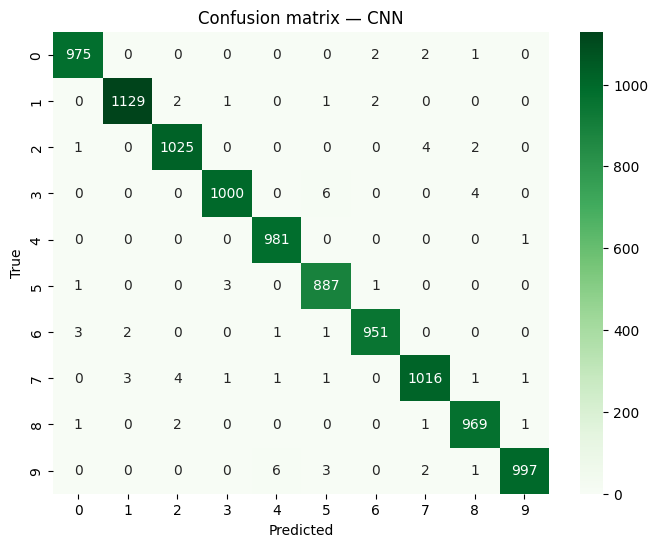

In [ ]:
test_loss_cnn, test_acc_cnn = cnn.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"CNN Test accuracy: {test_acc_cnn:.4f}, loss: {test_loss_cnn:.4f}")

y_pred_proba_cnn = cnn.predict(x_test_cnn)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

print("\nClassification report (CNN):")
print(classification_report(y_test, y_pred_cnn, digits=4))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plt.figure(figsize=(8,6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion matrix — CNN")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


Побудова графіків loss/accuracy для CNN

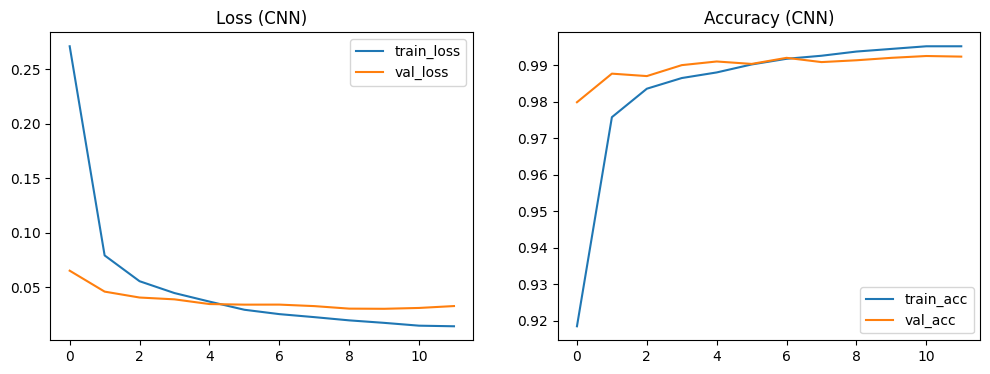

In [ ]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_cnn.history['loss'], label='train_loss')
plt.plot(history_cnn.history['val_loss'], label='val_loss')
plt.title('Loss (CNN)')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history_cnn.history['accuracy'], label='train_acc')
plt.plot(history_cnn.history['val_accuracy'], label='val_acc')
plt.title('Accuracy (CNN)')
plt.legend()
plt.show()


Розрахунок precision, recall, f1

In [ ]:
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_cnn, average='macro')
print(f"CNN Macro Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")


CNN Macro Precision: 0.9929, Recall: 0.9930, F1: 0.9930


Збереження моделі і приклад передбачення на новому малюнку

Model saved to mnist_cnn.h5


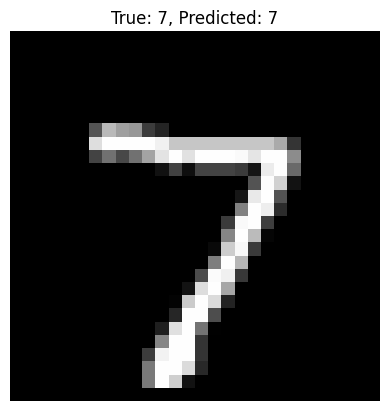

In [ ]:
model_path = "mnist_cnn.h5"
cnn.save(model_path)
print(f"Model saved to {model_path}")

# Приклад: прогноз для першого тестового зображення
idx = 0
plt.imshow(x_test[idx], cmap='gray')
plt.title(f"True: {y_test[idx]}, Predicted: {y_pred_cnn[idx]}")
plt.axis('off')
plt.show()


Наступний блок створює покращену CNN-модель із регуляризацією L2, нормалізацією пакетів (BatchNorm), dropout та аугментацією даних для підвищення узагальнювальної здатності. Він навчає модель із застосуванням callback’ів (EarlyStopping і ReduceLROnPlateau) та оцінює її точність на тестових даних, демонструючи реальне покращення продуктивності порівняно зі звичайною CNN.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 1) Аугментація даних
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

datagen.fit(x_train_cnn)

# 2) Покращена CNN-модель з L2 + BatchNorm + Dropout
def build_improved_cnn():
    model = models.Sequential([
        layers.Input(shape=(28,28,1)),

        layers.Conv2D(32, (3,3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), padding='same',
                      kernel_regularizer=regularizers.l2(0.001)),
        BatchNormalization(),
        layers.Activation('relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(10, activation='softmax')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

improved_cnn = build_improved_cnn()
improved_cnn.summary()

# 3) Callbacks: EarlyStopping + зниження learning rate
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.5, verbose=1)
]

# 4) Навчання з аугментацією
history_improved = improved_cnn.fit(
    datagen.flow(x_train_cnn, y_train_cat, batch_size=64),
    steps_per_epoch=len(x_train_cnn)//64,
    validation_data=(x_test_cnn, y_test_cat),
    epochs=20,
    callbacks=callbacks
)

# 5) Оцінка покращеної моделі
loss, acc = improved_cnn.evaluate(x_test_cnn, y_test_cat, verbose=0)
print(f"Improved CNN Test accuracy: {acc:.4f}, loss: {loss:.4f}")


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 422,026 (1.61 MB)

 Trainable params: 421,834 (1.61 MB)

 Non-trainable params: 192 (768.00 B)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 145s 149ms/step - accuracy: 0.5822 - loss: 1.2913 - val_accuracy: 0.9745 - val_loss: 0.1169 - learning_rate: 0.0010
Epoch 2/20
  1/937 ━━━━━━━━━━━━━━━━━━━━ 2:43 174ms/step - accuracy: 0.8906 - loss: 0.3294

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.8906 - loss: 0.3294 - val_accuracy: 0.9747 - val_loss: 0.1178 - learning_rate: 0.0010
Epoch 3/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 132s 141ms/step - accuracy: 0.8764 - loss: 0.4189 - val_accuracy: 0.9786 - val_loss: 0.1020 - learning_rate: 0.0010
Epoch 4/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9688 - loss: 0.1515 - val_accuracy: 0.9782 - val_loss: 0.1026 - learning_rate: 0.0010
Epoch 5/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 132s 141ms/step - accuracy: 0.9035 - loss: 0.3345 - val_accuracy: 0.9836 - val_loss: 0.0795 - learning_rate: 0.0010
Epoch 6/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9062 - loss: 0.2789 - val_accuracy: 0.9850 - val_loss: 0.0767 - learning_rate: 0.0010
Epoch 7/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 137s 142ms/step - accuracy: 0.9200 - loss: 0.2860 - val_accuracy: 0.9896 - val_loss: 0.0656 - learning_rate: 0.0010
Epoch 8/20
937/937 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9688 - loss: 0.1989 -

Графіки навчання для improved CNN

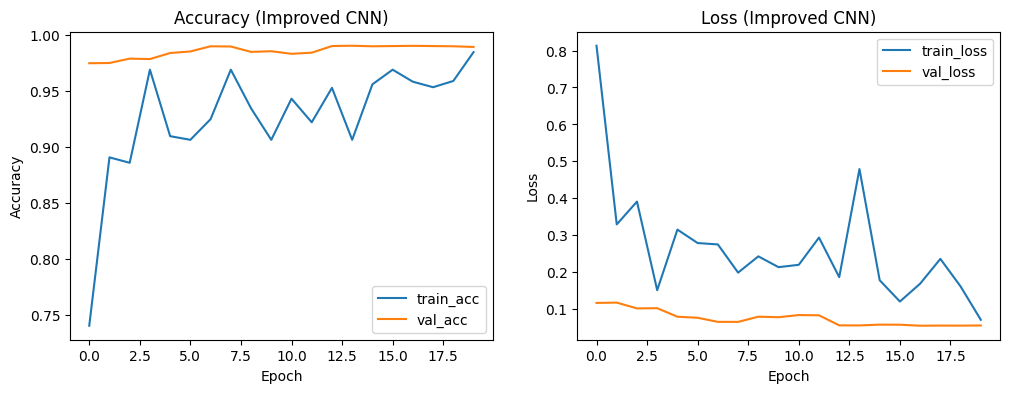

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_improved.history['accuracy'], label='train_acc')
plt.plot(history_improved.history['val_accuracy'], label='val_acc')
plt.title('Accuracy (Improved CNN)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_improved.history['loss'], label='train_loss')
plt.plot(history_improved.history['val_loss'], label='val_loss')
plt.title('Loss (Improved CNN)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


**Висновки лабораторної роботи:**

Виконуючи лабораторну роботу ми порівняли різні архітектури нейронних мереж для класифікації зображень, починаючи з базового MLP та переходячи до CNN. Було показано, що згорткові мережі значно покращують точність завдяки здатності виділяти просторові ознаки зображень. Додаткові покращення, такі як аугментація даних, L2-регуляризація, BatchNormalization та Dropout, дозволили підвищити узагальнювальну здатність моделі і знизити перенавчання. Загалом, результати підтверджують ефективність CNN і сучасних методів регуляризації для задач комп’ютерного зору.